# Assignment 1: Camera Calibration

Name: Tushar Choudhary  
Roll number: 2019111019

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import os

%matplotlib tk
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Question 1  
Implement the DLT (Direct Linear Transformation) based calibration that we discussed in the class. You could
use C/C++, Python or Matlab for this. However, you are expected to implement it yourselves and not use an
existing implementation.

**Answer**   
In the following cell, I have implemented DLT. I have contructed the matrix `M`, such that `Mp=0` where `p` is the column vector consisting of elements of the projection matrix. I have obtained the solution using SVD, where I have assigned `p` equal to the last column of `v` obtained via SVD. This function has then been used in the later questions.

In [3]:
def M(image_pts, world_pts):
    n = image_pts.shape[0] 
    npz = np.zeros(n)
    a_x = np.c_[-1*world_pts[:, 0], -1*world_pts[:, 1], -1*world_pts[:, 2], -1*np.ones(n), npz, npz, npz, npz, np.multiply(image_pts[:, 0], world_pts[:, 0]), np.multiply(image_pts[:, 0], world_pts[:, 1]), np.multiply(image_pts[:, 0], world_pts[:, 2]), image_pts[:, 0]]
    a_y = np.c_[npz, npz, npz, npz, -1*world_pts[:, 0], -1*world_pts[:, 1], -1*world_pts[:, 2], -1*np.ones(n), np.multiply(image_pts[:, 1], world_pts[:, 0]), np.multiply(image_pts[:, 1], world_pts[:, 1]), np.multiply(image_pts[:, 1], world_pts[:, 2]), image_pts[:, 1]]
    ans = np.empty((2 * n, a_x.shape[1]))
    ans[::2, :] = a_x
    ans[1::2, :] = a_y
    return ans

def DLT(x,X):
    m = M(x, X)
    u, d, v = np.linalg.svd(m)
    P = v[-1, :]
    P = P.reshape((3, 4))
    return P

## Question 2  
Implement the RANSAC based variant of the calibration that we discussed in the class. Note that these two
algorithms use a set of known correspondences between real-world points and image points.

**Answer**  
This method is used to filter the outliers. As DLT uses 6 points, in each iteration, I have picked 6 random points and calculated a P matrix for them. After that using this P, I projected the points on the image and calculated its distance from the original image point. If the distance is less than `delta` (default value = 30), then this point is counted as an inlier for this iteration. This process was repeated multiple times, and finally DLT was applied on the largest inlier set obtained.

In [4]:
def point_err(image_pt, world_pt, P):
    world_pt = np.append(world_pt, 1)
    projected_pt = P@world_pt
    projected_pt = projected_pt/projected_pt[-1]
    diff = image_pt - projected_pt[:2]
    return np.sqrt(diff[0]**2+diff[1]**2)

def RANSAC(image_points, world_points, p=1-(1e-15), e=0.4, s=3, delta=30):
    
    number_of_iterations = np.log2(1-p)/np.log2(1-(1-e)**s)
    number_of_iterations = number_of_iterations.astype(int) + 1
    print(f'Running {number_of_iterations} iterations of RANSAC.')
    max_inliers = -np.inf
    
    for _ in range(number_of_iterations):
        
        index = np.random.choice(image_points.shape[0], 6, replace=False)  
        image_points_random = image_points[index]
        world_points_random = world_points[index]
        P_temp = DLT(image_points_random, world_points_random)
        distances = [point_err(image_points[i], world_points[i], P_temp) for i in range(len(image_points))]
        distances = np.array(distances)
        inlier_count = (distances<delta).sum()
        
        if max_inliers < inlier_count:
            max_inliers = inlier_count
            indices = []
            for i in range(len(distances)):
                if distances[i]<delta:
                    indices.append(i)
            
    print(f'Gathered {max_inliers} inliers.')
    print('Inlier Indexes: ', indices)
    return DLT(image_points[indices], world_points[indices])

## Question 3 
Use the image that is provided along with this assignment along with the real-world measurements that are given
to you to compute the camera’s internal and external parameters using each of the above algorithms. Note that
you need to manually estimate the image co-ordinates of the given world points. You may implement and use
the Harris Corner detector to help select these points. Describe your observations regarding the results.

**Defining some utility functions for later help**:

In [5]:
# Function to plot image points [directly taken from my Mobile Robotics submission]
def image_points_plot(pth, image_points):
    N = len(image_points)
    image_points = np.array(image_points)
    fig = plt.figure(figsize=(10,15))
    img=mpimg.imread(pth)
    imgplot = plt.imshow(img)
    area = (8 * np.ones(N))**2 
    plt.scatter(image_points[:,0], image_points[:,1], c='r', s=area)
    plt.show()
    
# Function to get x, given P and X
def get_points(P,X):
    X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

# Function to calculate error after reprojecting
def get_err(x, X, P):
    points = get_points(P, X)
    diff = x[:, :2] - points
    err = np.linalg.norm(diff, axis=1)
    return np.mean(err ** 2)

# Function to return R, K and T for given P matrix
def ret_RKT(P):
    H_inf = P[:, :3]
    h = P[:, -1]
    T = -np.dot(np.linalg.inv(H_inf), h)
    R_tr, K_inv = np.linalg.qr(np.linalg.inv(H_inf))
    K = np.linalg.inv(K_inv)
    return R_tr.T, K/K[-1, -1], T

**Manually chossing points from the image**  
This points were obtained by manually clicking on the image. I was very careful during this, hence the probability of having outliers is low.


 Points manually chosen from the image:


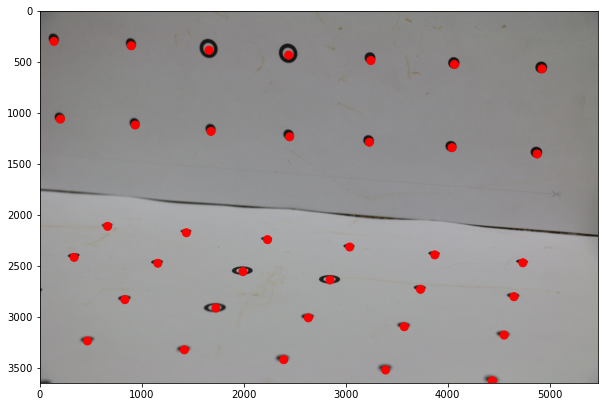

In [6]:
# Defining the image and world points in corresponding order
image_points = np.array([[4925.82454307,  569.56332161],[4877.57950909, 1404.20240961], [4737.66891052, 2470.41766075], [4650.82784934, 2803.30839527], [4554.33778136, 3179.61966038], [4438.54969979, 3628.29847647], [4067.06293808,  526.14279102], [4042.94042109, 1341.48386542], [3874.08280213, 2393.22560637], [3734.17220356, 2730.94084429], [3574.9635914 , 3097.6031026 ], [3391.63246224, 3522.1594017 ], [3246.89736028,  487.54676383], [3232.42385008, 1288.41432803], [3039.44371413, 2316.03355199], [2846.46357817, 2639.27527971], [2634.18542862, 3010.76204142], [2392.96025868, 3420.84483032], [2441.20529267,  434.47722644], [2450.85429947, 1235.34479065], [2233.75164652, 2243.66600101], [1992.52647658, 2557.25872193], [1727.17878964, 2914.27197344], [1418.41057212, 3324.35476235], [1659.63574206,  386.23219245], [1678.93375565, 1182.27525326], [1437.70858571, 2176.12295342], [1157.88738858, 2475.24216415], [ 834.64566086, 2832.25541566], [ 467.98340254, 3237.51370117], [ 897.36420504,  342.81166186], [ 935.96023223, 1119.55670908], [ 665.7880419 , 2113.40440924], [ 337.72181078, 2417.34812336], [ 139.91717142,  299.39113127], [ 202.63571561, 1061.66266829]])
world_points = np.array([[  0, 72,   0], [  0, 36,   0], [  0,  0,  36], [  0,  0,  72], [  0,  0, 108], [  0,  0, 144], [ 36, 72,   0], [ 36, 36,   0], [ 36,  0,  36], [ 36,  0,  72], [ 36,  0, 108], [ 36,  0, 144], [ 72, 72,   0], [ 72, 36,   0], [ 72,  0,  36], [ 72,  0,  72], [ 72,  0, 108], [ 72,  0, 144], [108, 72,   0], [108, 36,   0], [108,  0,  36], [108,  0,  72], [108,  0, 108], [108,  0, 144], [144, 72,   0], [144, 36,   0], [144,  0,  36], [144,  0,  72], [144,  0, 108], [144,  0, 144], [180, 72,   0], [180, 36,   0], [180,  0,  36], [180,  0,  72], [216, 72,   0], [216, 36,   0]])

# Plotting the manually chosen points
print('\n Points manually chosen from the image:')
image_points_plot('../data/black-dots.JPG', image_points)

**Running DLT for image provided**


 P matrix obtained via DLT:
 [[-2.10212865e+01 -1.66943260e+00 -9.73103950e+00  4.80790582e+03]
 [-1.10951289e+00 -2.24795464e+01  4.31700975e+00  2.16938536e+03]
 [ 3.44057754e-04 -6.73488508e-04 -1.61290756e-03  1.00000000e+00]]

 R matrix obtained via DLT:
 [[-0.97731676  0.007592   -0.21164668]
 [-0.08688989 -0.92574827  0.36802213]
 [-0.19313753  0.37806415  0.90540896]]

 K matrix obtained via DLT:
 [[-1.26816857e+04  1.17449612e+02  3.02104166e+03]
 [-0.00000000e+00 -1.26279297e+04  2.45634341e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 T matrix obtained via DLT:
 [-32.34097404 199.81845723 529.66296684]

 Error after reprojecting the points:  73.18826041429014

 World points reprojected back to the image using the P matrix:


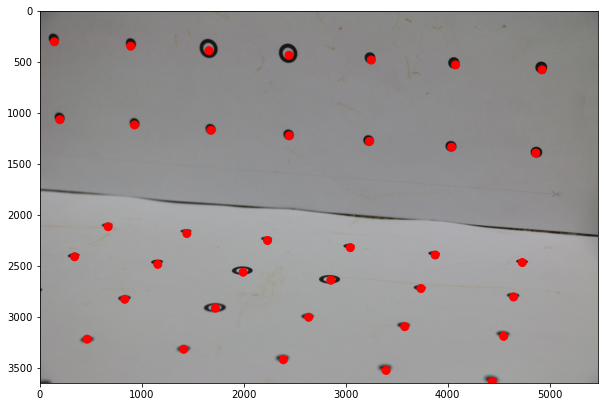

In [7]:
# Finding the projection matrix P using DLT
P = DLT(image_points, world_points)
R, K, T = ret_RKT(P)

# Printing the P, R, K, T matrices obtained
print('\n P matrix obtained via DLT:\n', P/P[-1, -1])
print('\n R matrix obtained via DLT:\n', R)
print('\n K matrix obtained via DLT:\n', K)
print('\n T matrix obtained via DLT:\n', T)

# Printing the reprojection error
print('\n Error after reprojecting the points: ', get_err(image_points, world_points, P))

# Plotting the world points projected onto the image using the P matrix
print('\n World points reprojected back to the image using the P matrix:')
image_points_plot('../data/black-dots.JPG', get_points(P, world_points))

**Running RANSAC for image provided**

Running 142 iterations of RANSAC.
Gathered 36 inliers.
Inlier Indexes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

 P matrix obtained via RANSAC:
 [[-2.10212865e+01 -1.66943260e+00 -9.73103950e+00  4.80790582e+03]
 [-1.10951289e+00 -2.24795464e+01  4.31700975e+00  2.16938536e+03]
 [ 3.44057754e-04 -6.73488508e-04 -1.61290756e-03  1.00000000e+00]]

 R matrix obtained via RANSAC:
 [[-0.97731676  0.007592   -0.21164668]
 [-0.08688989 -0.92574827  0.36802213]
 [-0.19313753  0.37806415  0.90540896]]

 K matrix obtained via RANSAC:
 [[-1.26816857e+04  1.17449612e+02  3.02104166e+03]
 [-0.00000000e+00 -1.26279297e+04  2.45634341e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 T matrix obtained via RANSAC:
 [-32.34097404 199.81845723 529.66296684]

 Error after reprojecting the points:  73.18826041429014

 World points reprojected back to the image using the P matrix:


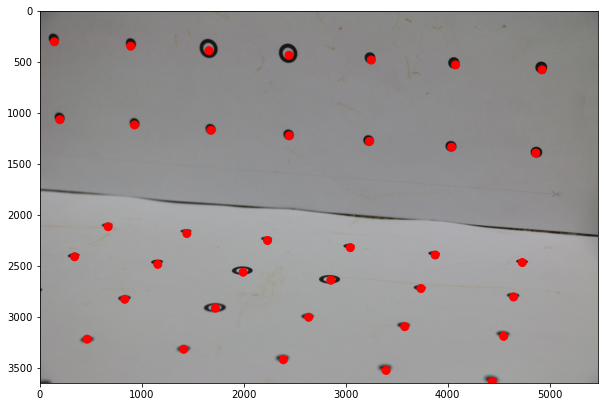

In [8]:
# Finding the projection matrix P using RANSAC
P = RANSAC(image_points, world_points)
R, K, T = ret_RKT(P)

# Printing the P, R, K, T matrices obtained
print('\n P matrix obtained via RANSAC:\n', P/P[-1, -1])
print('\n R matrix obtained via RANSAC:\n', R)
print('\n K matrix obtained via RANSAC:\n', K)
print('\n T matrix obtained via RANSAC:\n', T)

# Printing the reprojection error
print('\n Error after reprojecting the points: ', get_err(image_points, world_points, P))

# Plotting the world points projected onto the image using the P matrix
print('\n World points reprojected back to the image using the P matrix:')
image_points_plot('../data/black-dots.JPG', get_points(P, world_points))

**Observations**  
* We were successfully able to obtain the Projection matrix P. On using this projection matrix P to project the world points back on to the image, we see that the points lie on expected positions.
* The error on reprojecting the points back is quite low.
* We are successfully able to obtain K, R, and T matrices from the projection matrix. While doing rough work, I was trying to calculate P matrix back using these matrices, I was successfully able to generate the original P.
* The structure of the K, R, T matrices are as we expect them to be. R is an orthogonal matrix with Det(R)=1, for K we can see `K[0,0[=k[1,1]`, etc.
* Since the points were selected with precision, the RANSAC algorithm didn't find any outliers and were obtained the same values.

## Question 4
Repeat the above experiments after correcting for radial distortion. Estimate the radial distortion parameters
from the straight lines in the image. What do you observe regarding the resulting parameters?

**Answer**  
In the following cell I have written code for correction of radial distortion. I have printed the parameters along with the original and corrected image.


Radial distortion parameters :  [[ 0.32554581 -1.79090472  0.01081199  0.05104949  6.46518424]]


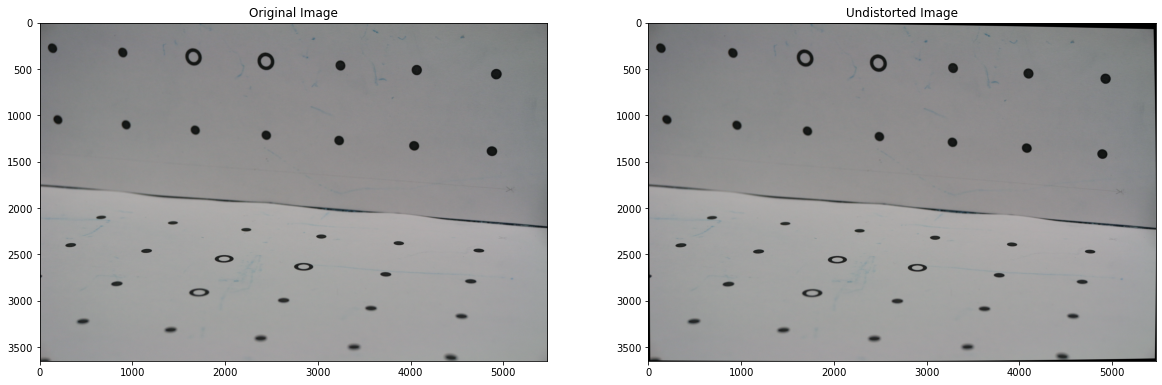

In [9]:
img = cv2.imread('../data/black-dots.JPG')
R,K,T = ret_RKT(P)
K = np.array(K)
K[0,1] = 0
K[0, 0] = -K[0, 0]
K[1, 1] = -K[1, 1]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(np.array([world_points]).astype(np.float32), 
                                                   np.array([image_points]).astype(np.float32),
                                                   (img.shape[1],img.shape[0]),
                                                   K, None, None,flags=(cv2.CALIB_USE_INTRINSIC_GUESS ))

print("\nRadial distortion parameters : ", dist)

h,w = img.shape[:2]
newK,roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))

I_corrected = cv2.undistort(img,mtx,dist,None,newK)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(I_corrected)
plt.title('Undistorted Image')
plt.show()

**Observations**  
We see that the radial distortion parameters were not insignificant. We can notice the changes in images before and after the correction. On looking carefully (or measuring), we can see that the distance between points lying on opposite corners have reduced. This tells us that real world cameras have some error due to radial distortion, and this given image is effected as well.


 Points manually chosen from the image:


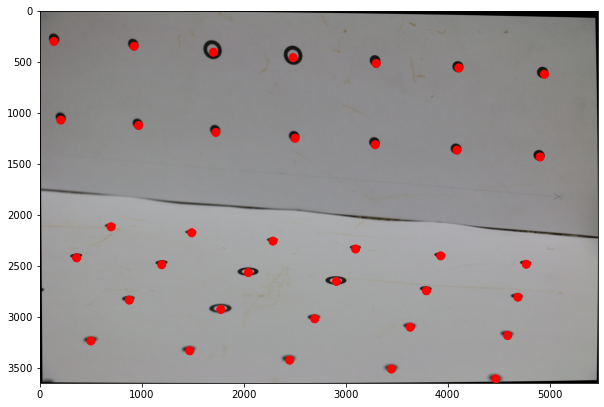

In [10]:
# Defining the image and world points in corresponding order
image_points = np.array([[4949.94706006824, 622.632858994366], [4906.526529478667, 1433.1494299997353], [4771.4404343111055, 2484.8911709471786], [4689.4238765308, 2808.132898669558], [4588.109305155129, 3184.4441637791942], [4472.321223582933, 3609.000462877245], [4110.483468669822, 559.9143148094267], [4091.1854550744565, 1365.6063824159546], [3931.976842912687, 2402.8746131668736], [3792.0662443462843, 2745.4143544846193], [3632.857632184515, 3102.427605998889], [3449.526503028539, 3512.510394900415], [3299.9668976644525, 516.4937842198533], [3290.3178908667696, 1312.5368450286983], [3097.337754913111, 2335.331565583093], [2909.182122358293, 2653.748789906631], [2696.9039728092675, 3020.4110482185833], [2450.854299468352, 3425.6693337212682], [2484.625823260242, 458.5997434337555], [2503.923836855608, 1249.818300843759], [2286.821183907741, 2258.139511201629], [2045.5960139656675, 2566.907728727484], [1775.4238236305443, 2928.7454836405955], [1471.4801095035307, 3334.00376914328], [1703.0562726479222, 405.5302060464992], [1727.1787896421295, 1191.9242600576613], [1490.778123098897, 2176.122953421324], [1196.4834157695661, 2489.71567434602], [878.0661914460286, 2837.079919062607], [501.7549263363928, 3237.5137011664506], [926.3112254344435, 347.6361652604014], [969.7317560240165, 1124.3812124738802], [699.5595656888934, 2118.228912635226], [361.8443277699896, 2422.17262676224], [139.9171714232814, 299.3911312719865], [207.46021900706205, 1071.3116750866238]])
world_points = np.array([[  0, 72,   0], [  0, 36,   0], [  0,  0,  36], [  0,  0,  72], [  0,  0, 108], [  0,  0, 144], [ 36, 72,   0], [ 36, 36,   0], [ 36,  0,  36], [ 36,  0,  72], [ 36,  0, 108], [ 36,  0, 144], [ 72, 72,   0], [ 72, 36,   0], [ 72,  0,  36], [ 72,  0,  72], [ 72,  0, 108], [ 72,  0, 144], [108, 72,   0], [108, 36,   0], [108,  0,  36], [108,  0,  72], [108,  0, 108], [108,  0, 144], [144, 72,   0], [144, 36,   0], [144,  0,  36], [144,  0,  72], [144,  0, 108], [144,  0, 144], [180, 72,   0], [180, 36,   0], [180,  0,  36], [180,  0,  72], [216, 72,   0], [216, 36,   0]])

# Plotting the manually chosen points
print('\n Points manually chosen from the image:')
image_points_plot('../data/radial.jpg', image_points)


 P matrix obtained via DLT:
 [[-2.11656966e+01 -1.79339200e+00 -9.72428294e+00  4.84923232e+03]
 [-1.39460320e+00 -2.20448614e+01  4.20373849e+00  2.18662518e+03]
 [ 2.16440369e-04 -6.52906157e-04 -1.59085329e-03  1.00000000e+00]]

 R matrix obtained via DLT:
 [[-0.98832034  0.03420526 -0.14850222]
 [-0.08733813 -0.9257004   0.36803645]
 [-0.12487978  0.37670781  0.91787595]]

 K matrix obtained via DLT:
 [[-1.28671550e+04  4.04886168e+01  4.01462233e+03]
 [-0.00000000e+00 -1.27371320e+04  2.46470593e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 T matrix obtained via DLT:
 [-36.2040283  204.40999372 539.77538369]

 Error after reprojecting the points:  72.12254618883222

 World points reprojected back to the image using the P matrix:


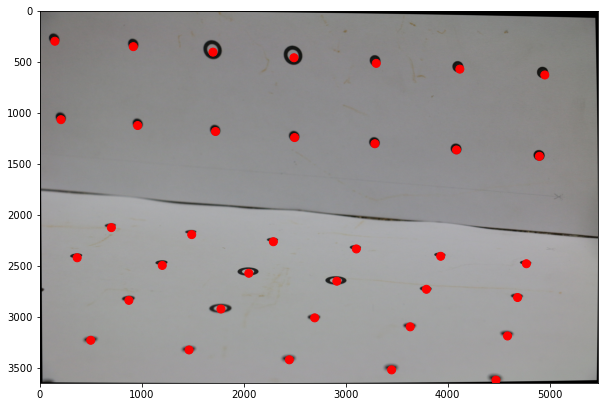

In [11]:
# Finding the projection matrix P using DLT
P = DLT(image_points, world_points)
R, K, T = ret_RKT(P)

# Printing the P, R, K, T matrices obtained
print('\n P matrix obtained via DLT:\n', P/P[-1, -1])
print('\n R matrix obtained via DLT:\n', R)
print('\n K matrix obtained via DLT:\n', K)
print('\n T matrix obtained via DLT:\n', T)

# Printing the reprojection error
print('\n Error after reprojecting the points: ', get_err(image_points, world_points, P))

# Plotting the world points projected onto the image using the P matrix
print('\n World points reprojected back to the image using the P matrix:')
image_points_plot('../data/radial.jpg', get_points(P, world_points))

Running 142 iterations of RANSAC.
Gathered 36 inliers.
Inlier Indexes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

 P matrix obtained via DLT:
 [[-2.11656966e+01 -1.79339200e+00 -9.72428294e+00  4.84923232e+03]
 [-1.39460320e+00 -2.20448614e+01  4.20373849e+00  2.18662518e+03]
 [ 2.16440369e-04 -6.52906157e-04 -1.59085329e-03  1.00000000e+00]]

 R matrix obtained via DLT:
 [[-0.98832034  0.03420526 -0.14850222]
 [-0.08733813 -0.9257004   0.36803645]
 [-0.12487978  0.37670781  0.91787595]]

 K matrix obtained via DLT:
 [[-1.28671550e+04  4.04886168e+01  4.01462233e+03]
 [-0.00000000e+00 -1.27371320e+04  2.46470593e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 T matrix obtained via DLT:
 [-36.2040283  204.40999372 539.77538369]

 Error after reprojecting the points:  72.12254618883222

 World points reprojected back to the image using the P matrix:


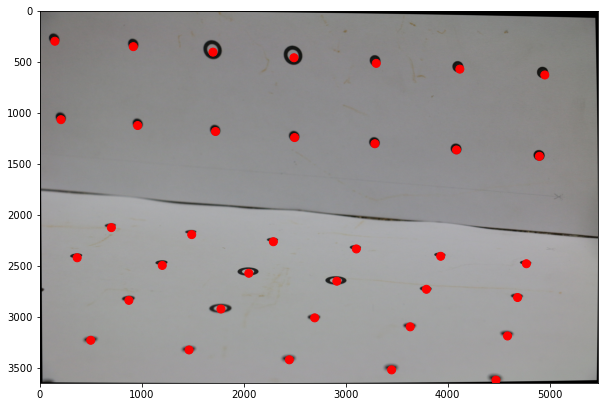

In [12]:
# Finding the projection matrix P using RANSAC
P = RANSAC(image_points, world_points)
R, K, T = ret_RKT(P)

# Printing the P, R, K, T matrices obtained
print('\n P matrix obtained via DLT:\n', P/P[-1, -1])
print('\n R matrix obtained via DLT:\n', R)
print('\n K matrix obtained via DLT:\n', K)
print('\n T matrix obtained via DLT:\n', T)

# Printing the reprojection error
print('\n Error after reprojecting the points: ', get_err(image_points, world_points, P))

# Plotting the world points projected onto the image using the P matrix
print('\n World points reprojected back to the image using the P matrix:')
image_points_plot('../data/radial.jpg', get_points(P, world_points))

**Observation**  
We have observations similar to the last time. One important observation is to make is that some values are quite different compared from the original values from Q3. This is probably due to the shift of points after correction. Hence, this confirms our last observation, radial distortion is not insignificant in the given image.

## Question 5 
Use the real-world measurements that are provided along with the estimated camera parameters to compute the
image of a wireframe of the object. Note that you will be computing the location of image points as xi = P.Xi,
and not use the image points. Overlay (draw) the wireframe over the actual image of the object using straight
lines between the computed points xi. What do you observe about the overlay?

**Answer**  
To plot the wireframe, I have directly plotted a line between images of extreme points on an axis. I have done this for both original and radially corrected image and discussed my observations afterwards.

In [13]:
def draw_wireframe(start,end):
    start = np.append(start, 1)
    projected_pt = P@start
    u1=projected_pt[0]/projected_pt[-1]
    v1=projected_pt[1]/projected_pt[-1]
    end = np.append(end, 1)
    projected_pt = P@end
    u2=projected_pt[0]/projected_pt[-1]
    v2=projected_pt[1]/projected_pt[-1]
    cv2.line(image,(int(u1),int(v1)),(int(u2),int(v2)),(0,0,255),20)
    cv2.circle(image,(int(u1),int(v1)),6,(0,255,0),60)
    cv2.circle(image,(int(u2),int(v2)),6,(0,255,0),60)

def horizontal():
    for i in range(0, 3): draw_wireframe((0, 36*i, 0),(216, 36*i, 0))
    for i in range(0, 5): draw_wireframe((0, 0, 36*i),(216, 0, 36*i))

def vertical():
    for i in range(0, 7): draw_wireframe((36*i, 0, 0),(i*36, 72, 0))
    for i in range(0, 7): draw_wireframe((36*i, 0, 0),(i*36, 0, 144))

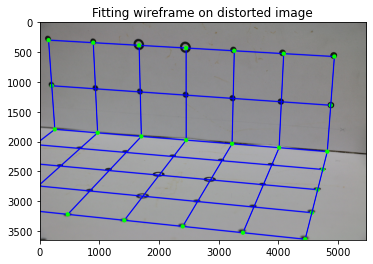

In [14]:
image_points = np.array([[4925.82454307,  569.56332161],[4877.57950909, 1404.20240961], [4737.66891052, 2470.41766075], [4650.82784934, 2803.30839527], [4554.33778136, 3179.61966038], [4438.54969979, 3628.29847647], [4067.06293808,  526.14279102], [4042.94042109, 1341.48386542], [3874.08280213, 2393.22560637], [3734.17220356, 2730.94084429], [3574.9635914 , 3097.6031026 ], [3391.63246224, 3522.1594017 ], [3246.89736028,  487.54676383], [3232.42385008, 1288.41432803], [3039.44371413, 2316.03355199], [2846.46357817, 2639.27527971], [2634.18542862, 3010.76204142], [2392.96025868, 3420.84483032], [2441.20529267,  434.47722644], [2450.85429947, 1235.34479065], [2233.75164652, 2243.66600101], [1992.52647658, 2557.25872193], [1727.17878964, 2914.27197344], [1418.41057212, 3324.35476235], [1659.63574206,  386.23219245], [1678.93375565, 1182.27525326], [1437.70858571, 2176.12295342], [1157.88738858, 2475.24216415], [ 834.64566086, 2832.25541566], [ 467.98340254, 3237.51370117], [ 897.36420504,  342.81166186], [ 935.96023223, 1119.55670908], [ 665.7880419 , 2113.40440924], [ 337.72181078, 2417.34812336], [ 139.91717142,  299.39113127], [ 202.63571561, 1061.66266829]])
world_points = np.array([[  0, 72,   0], [  0, 36,   0], [  0,  0,  36], [  0,  0,  72], [  0,  0, 108], [  0,  0, 144], [ 36, 72,   0], [ 36, 36,   0], [ 36,  0,  36], [ 36,  0,  72], [ 36,  0, 108], [ 36,  0, 144], [ 72, 72,   0], [ 72, 36,   0], [ 72,  0,  36], [ 72,  0,  72], [ 72,  0, 108], [ 72,  0, 144], [108, 72,   0], [108, 36,   0], [108,  0,  36], [108,  0,  72], [108,  0, 108], [108,  0, 144], [144, 72,   0], [144, 36,   0], [144,  0,  36], [144,  0,  72], [144,  0, 108], [144,  0, 144], [180, 72,   0], [180, 36,   0], [180,  0,  36], [180,  0,  72], [216, 72,   0], [216, 36,   0]])
P = DLT(image_points, world_points)
image = mpimg.imread('../data/black-dots.JPG')
horizontal()
vertical()
plt.title('Fitting wireframe on distorted image')
plt.imshow(image)
plt.show()

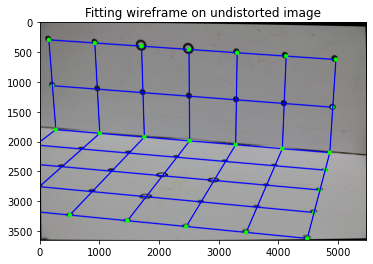

In [15]:
image_points = np.array([[4949.94706006824, 622.632858994366], [4906.526529478667, 1433.1494299997353], [4771.4404343111055, 2484.8911709471786], [4689.4238765308, 2808.132898669558], [4588.109305155129, 3184.4441637791942], [4472.321223582933, 3609.000462877245], [4110.483468669822, 559.9143148094267], [4091.1854550744565, 1365.6063824159546], [3931.976842912687, 2402.8746131668736], [3792.0662443462843, 2745.4143544846193], [3632.857632184515, 3102.427605998889], [3449.526503028539, 3512.510394900415], [3299.9668976644525, 516.4937842198533], [3290.3178908667696, 1312.5368450286983], [3097.337754913111, 2335.331565583093], [2909.182122358293, 2653.748789906631], [2696.9039728092675, 3020.4110482185833], [2450.854299468352, 3425.6693337212682], [2484.625823260242, 458.5997434337555], [2503.923836855608, 1249.818300843759], [2286.821183907741, 2258.139511201629], [2045.5960139656675, 2566.907728727484], [1775.4238236305443, 2928.7454836405955], [1471.4801095035307, 3334.00376914328], [1703.0562726479222, 405.5302060464992], [1727.1787896421295, 1191.9242600576613], [1490.778123098897, 2176.122953421324], [1196.4834157695661, 2489.71567434602], [878.0661914460286, 2837.079919062607], [501.7549263363928, 3237.5137011664506], [926.3112254344435, 347.6361652604014], [969.7317560240165, 1124.3812124738802], [699.5595656888934, 2118.228912635226], [361.8443277699896, 2422.17262676224], [139.9171714232814, 299.3911312719865], [207.46021900706205, 1071.3116750866238]])
world_points = np.array([[  0, 72,   0], [  0, 36,   0], [  0,  0,  36], [  0,  0,  72], [  0,  0, 108], [  0,  0, 144], [ 36, 72,   0], [ 36, 36,   0], [ 36,  0,  36], [ 36,  0,  72], [ 36,  0, 108], [ 36,  0, 144], [ 72, 72,   0], [ 72, 36,   0], [ 72,  0,  36], [ 72,  0,  72], [ 72,  0, 108], [ 72,  0, 144], [108, 72,   0], [108, 36,   0], [108,  0,  36], [108,  0,  72], [108,  0, 108], [108,  0, 144], [144, 72,   0], [144, 36,   0], [144,  0,  36], [144,  0,  72], [144,  0, 108], [144,  0, 144], [180, 72,   0], [180, 36,   0], [180,  0,  36], [180,  0,  72], [216, 72,   0], [216, 36,   0]])
P = DLT(image_points, world_points)
image = mpimg.imread('../data/radial.jpg')
horizontal()
vertical()
plt.title('Fitting wireframe on undistorted image')
plt.imshow(image)
plt.show()

**Observations**
* Straight lines in real world reproject to straight lines in an image.
* Lines which are parallel in the real world, don't remain parallel in images. We can see from the plots that for pair of lines, that we know are parallel in the real world, seem to meet at a point in the image.
* On checking carefully, lines seem to fit better on the points (points lie on the line) in the radially corrected image. This is because the points in this image don't bulge out due to radial distortion.

## Question 6  
Repeat the calibration of the camera using Zhang’s method using either the available OpenCV or Matlab
implementation. How does your results compare with DLT based method?

**Answer**  
In the cell below I have applied Zhang, by using `6x8` points from the given images of the chess board. In the output I have printed the K matrix for the camera, and some other parameters as well.

In [16]:
zhang_images = glob.glob("../data/Zhangs/checkerboard*.JPG")
zhang_images.sort()

objpoints = []
imgpoints = [] 
objp = np.zeros((48,3), np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)

for zhang_img in zhang_images:
    print('Opening ', zhang_img, end='')
    img = cv2.imread(zhang_img)
    gray = cv2.cvtColor(img[:],cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (6, 8),None)
    if ret == True:
        print (".   Corners detected successfully!")
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        objpoints.append(objp)
        imgpoints.append(corners2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print("\nRet:\n",ret)
print("\nDist:\n",dist)
print("\nRvecs:\n",rvecs)
print("\nTvecs:\n",tvecs)
print("\nK:\n",mtx)

Opening  ../data/Zhangs/checkerboard-01.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-02.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-03.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-04.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-05.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-06.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-07.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-08.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-09.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-10.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-11.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-12.JPG.   Corners detected successfully!
Opening  ../data/Zhangs/checkerboard-13.JPG.   Corners detected 

**Observations**
* The function was able to detect all `6x8` points in each of the images. 
* The obtained camera intrinsic matrix follows the structure we expect it to follow. The **constraints on K seem to be followed more strictly compared to DLT**. For example, this time we can see K[0, 1] = K[1, 0] = K[2, 1] = K[2, 1] = 0, and the values for K[0, 0] and K[1, 1] seem to be closer.

## Question 7
Repeat the overlay of wireframe using the internal parameters estimated from Zhang’s method. Describe your
observations.

**Answer**  
In the cell below I have printed the corners and the lines based on nearest points. All images with the points marked have been printed after that.

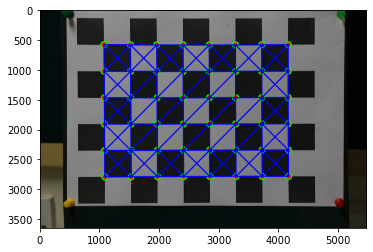

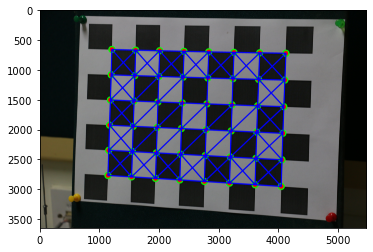

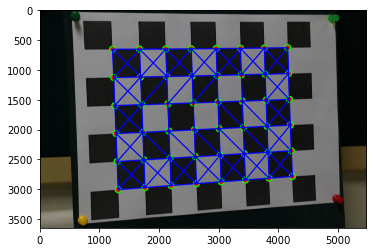

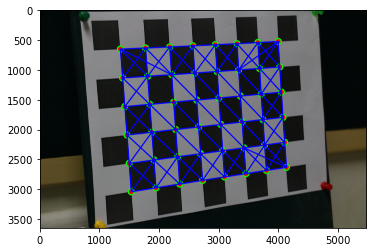

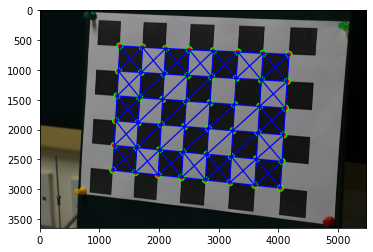

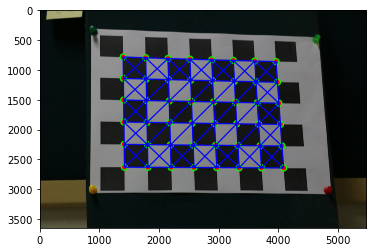

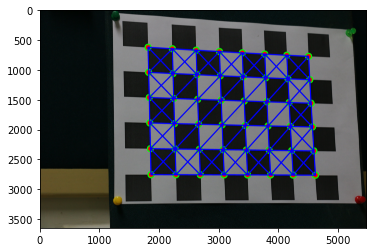

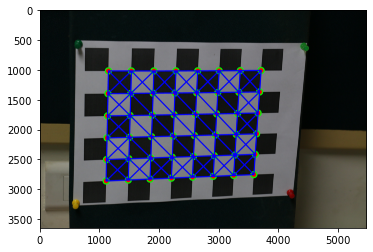

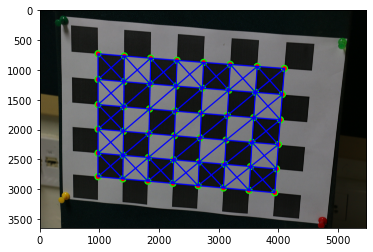

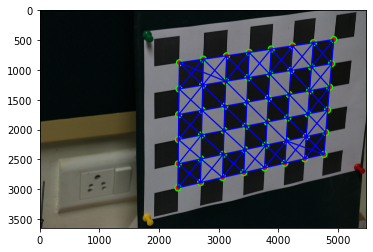

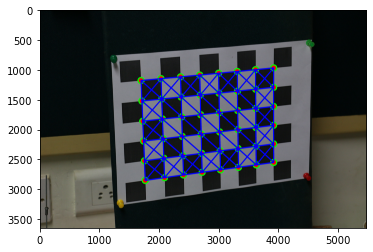

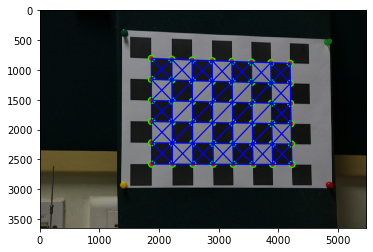

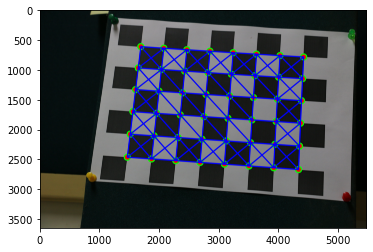

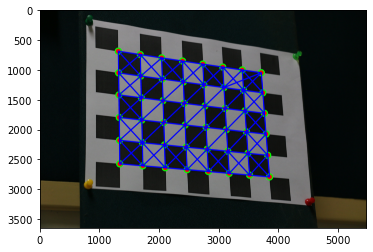

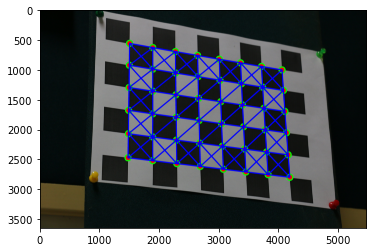

In [17]:
def zhang_plot(corners,filename):
    img = mpimg.imread(filename)
    for (u, v) in corners: img = cv2.circle(img, (u, v), 50, (255, 0, 0), -1)
    for (u, v) in corners: img = cv2.circle(img, (u, v), 50, (0, 255, 0), 20)
    for p in corners:
        distance = np.sum((corners - p)*(corners - p), axis=1)
        for nearest_corner in corners[np.argsort(distance)[0:6]]:
            img = cv2.line(img, tuple(p), tuple(nearest_corner), (0, 0, 255), 20)
    return img
    
for i in range(len(objpoints)):
    img_points = np.array(cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],mtx,dist)[0]).reshape(48,2)
    img = zhang_plot(img_points,zhang_images[i])
    plt.imshow(img)
    plt.show()

**Observations**  
We were able to obtain the lines, and again we notice that straight lines in real world correspond to straight lines in an image. However, parallel lines no longer remain parallel and seem to meet at a point. Also, the **wireframe seems to fit better in this case compared to DLT**.

## Question 8
What is the image of the world origin, given the calibration matrix? Does this result bear out in your
observations?

**Answer**  
Given the projection matrix P and a world point X, we can get its image as `x = PX`. Since the P obtained using DLT and Zhang's is similar, let's run it for one case and see the output. Assuming the following values, we will calculate the image location: 
* P matrix obtained using RANSAC = 
$$
\left(\begin{array}{cc} 
-2.10212865e+01 & -1.66943260e+00 & -9.73103950e+00 & 4.80790582e+03\\
-1.10951289e+00 & -2.24795464e+01 & 4.31700975e+00 & 2.16938536e+03\\
3.44057754e-04 & -6.73488508e-04 & -1.61290756e-03 & 1.00000000e+00
\end{array}\right)
$$
* World frame origin, X = [0 0 0 1].   



Image of the world origin is:  [4807.90582 2169.38536]


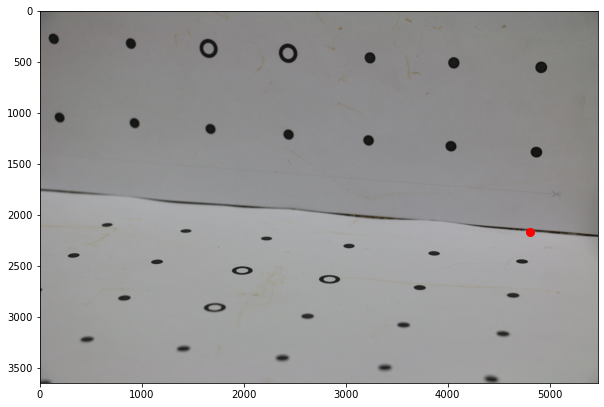

In [18]:
P = [[-2.10212865e+01, -1.66943260e+00, -9.73103950e+00,  4.80790582e+03],
 [-1.10951289e+00, -2.24795464e+01,  4.31700975e+00,  2.16938536e+03],
 [ 3.44057754e-04, -6.73488508e-04, -1.61290756e-03,  1.00000000e+00]]
X = [0, 0, 0, 1]
P = np.array(P)
X = np.array(X)
x = P@X
x = x/x[2]
x = x[:2]
print("\n\nImage of the world origin is: ", x)
image_points_plot('../data/black-dots.JPG', [x])

As we can see from the above output, the image of the world frame origin has been projected right on the spot we expect it to be.

## Question 9
Select a camera that you would like to use for the assignments. Note that you might be using this camera for
future assignments also. This could be your laptop camera, mobile phone camera or any other digital camera
that you have access to.  

**Answer**  
I will be using my phone's camera for this part of the assignment.

## Question 10
Repeat the 3 calibration methods using your own camera and your own calibration object for which you measure
and determine the world co-ordinates. Use a printed checkerboard pattern for Zhang’s method. Describe and
comment on the results of each method.

**Defining the world points and corresponsing image points and plotting them**  
Here, I have obtained the image points by manually clicking on the image. To get the world points, I have defined a world coordinate system where:
* X-axis is along the center of the page from top to bottm
* Y-axis is along the right page from left to right
* Z-axis is along the left page from right to left  

The setup of the world origin is similar to the one in the image given, but this time its on the other side of the page (top half), and we are following a right handed system.

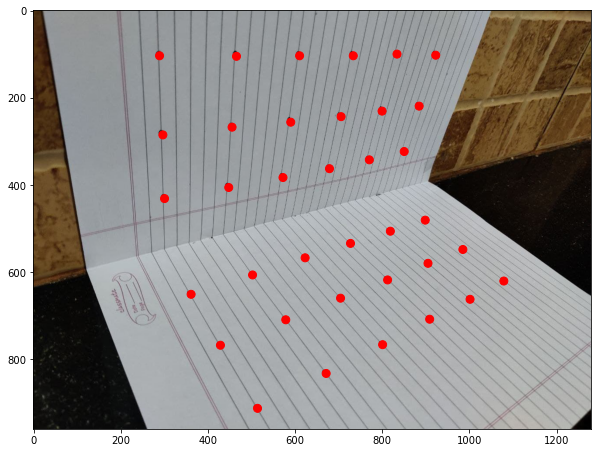

In [19]:
# Defining the image and world points in corresponding order
image_points = np.array([[513.8089903986034, 912.5499642923268], [671.2401539397466, 832.5647763641654], [800.7399820139129, 766.5452561694924], [908.6565054090514, 708.1433729203586], [1001.3377549131113, 662.4375512471236], [1078.7837305260932, 620.5405480466579], [428.7453778400826, 767.8148623270822], [578.5589044356865, 709.4129790779484], [704.2499140370832, 659.8983389319437], [812.1664374322216, 618.0013357314783], [904.8476869362818, 579.9131510037823], [984.8328748644432, 548.1729970640357], [361.4562514878197, 651.0110958288147], [502.38253498029474, 606.5748803131695], [622.9951199513317, 567.2170894278837], [727.1028248737008, 534.2073293305473], [818.5144682201709, 506.2759938635702], [898.4996561483323, 480.88387071177294], [300.5151559235062, 431.36923056576825], [447.7894702039306, 405.977107413971], [572.2108736477372, 383.12419657735336], [678.8577908852859, 362.81049805591556], [770.269434231756, 342.49679953447776], [850.2546221599176, 323.45270717062976], [296.70633745073667, 285.3645224429339], [455.40710714946965, 267.5900362366757], [589.9853598539954, 256.163580818367], [705.519520194673, 243.46751924246837], [799.4703758563229, 230.77145766656963], [884.533988414844, 219.34500224826093], [289.0887005051974, 103.81084190758327], [465.56395641018855, 105.08044806517307], [610.2990583754332, 103.81084190758327], [733.45085566165, 103.81084190758327], [833.7497421112492, 100.00202343481362], [922.6221731425397, 102.54123574999335]])
world_points = np.array([[0, 0, 12], [4, 0, 12], [8, 0, 12], [12, 0, 12], [16, 0, 12], [20, 0, 12], [0, 0, 8], [4, 0, 8], [8, 0, 8], [12, 0, 8], [16, 0, 8], [20, 0, 8], [0, 0, 4], [4, 0, 4], [8, 0, 4], [12, 0, 4], [16, 0, 4], [20, 0, 4], [0, 4, 0], [4, 4, 0], [8, 4, 0], [12, 4, 0], [16, 4, 0], [20, 4, 0], [0, 8, 0], [4, 8, 0], [8, 8, 0], [12, 8, 0], [16, 8, 0], [20, 8, 0], [0, 12, 0], [4, 12, 0], [8, 12, 0], [12, 12, 0], [16, 12, 0], [20, 12, 0]])

# Plotting the manually chosen points
image_points_plot('../data/Q10/world.jpg', image_points)

**Running DLT for my camera**


 P matrix obtained via DLT:
 [[ 4.25253998e+01 -6.91884271e+00  6.19494716e+00  3.04435940e+02]
 [ 1.77396482e+00 -3.95995912e+01  9.72834084e+00  5.56395304e+02]
 [ 2.00731813e-02 -2.00059561e-02 -2.19300132e-02  1.00000000e+00]]

 R matrix obtained via DLT:
 [[-0.80093751 -0.17644138 -0.57216041]
 [-0.21145261 -0.81066625  0.54599269]
 [-0.56016684  0.55829084  0.61198402]]

 K matrix obtained via DLT:
 [[ 1.01533813e+03  2.34069790e-02  6.66759034e+02]
 [-0.00000000e+00 -1.03360623e+03  4.78542090e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 T matrix obtained via DLT:
 [-7.21172129 19.04082724 21.62825229]

 Error after reprojecting the points:  4.141471282003002

 World points reprojected back to the image using the P matrix:


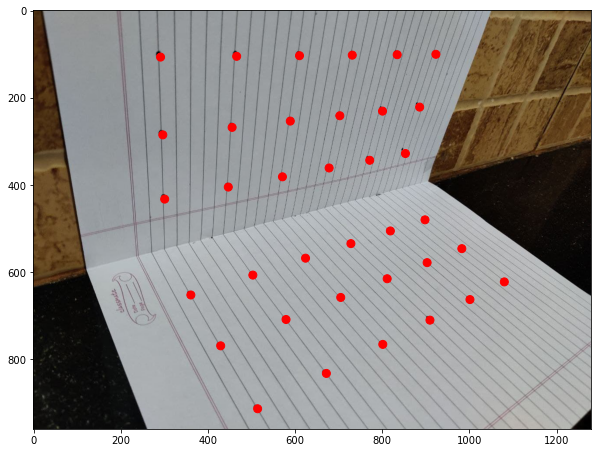

In [20]:
# Finding the projection matrix P using DLT
P = DLT(image_points, world_points)
R, K, T = ret_RKT(P)

# Printing the P, R, K, T matrices obtained
print('\n P matrix obtained via DLT:\n', P/P[-1, -1])
print('\n R matrix obtained via DLT:\n', R)
print('\n K matrix obtained via DLT:\n', K)
print('\n T matrix obtained via DLT:\n', T)

# Printing the reprojection error
print('\n Error after reprojecting the points: ', get_err(image_points, world_points, P))

# Plotting the world points projected onto the image using the P matrix
print('\n World points reprojected back to the image using the P matrix:')
image_points_plot('../data/Q10/world.jpg', get_points(P, world_points))

**Running RANSAC for my camera**

Running 142 iterations of RANSAC.
Gathered 36 inliers.
Inlier Indexes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

 P matrix obtained via RANSAC:
 [[ 4.25253998e+01 -6.91884271e+00  6.19494716e+00  3.04435940e+02]
 [ 1.77396482e+00 -3.95995912e+01  9.72834084e+00  5.56395304e+02]
 [ 2.00731813e-02 -2.00059561e-02 -2.19300132e-02  1.00000000e+00]]

 R matrix obtained via RANSAC:
 [[-0.80093751 -0.17644138 -0.57216041]
 [-0.21145261 -0.81066625  0.54599269]
 [-0.56016684  0.55829084  0.61198402]]

 K matrix obtained via RANSAC:
 [[ 1.01533813e+03  2.34069790e-02  6.66759034e+02]
 [-0.00000000e+00 -1.03360623e+03  4.78542090e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 T matrix obtained via RANSAC:
 [-7.21172129 19.04082724 21.62825229]

 Error after reprojecting the points:  4.141471282003002

 World points reprojected back to the image using the P matrix:


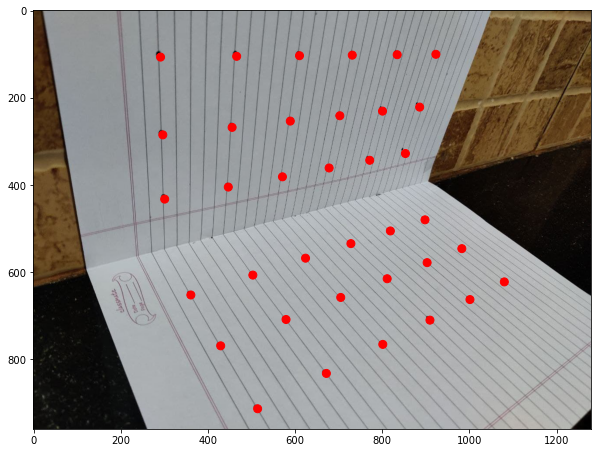

In [21]:
# Finding the projection matrix P using RANSAC
P = P = RANSAC(image_points, world_points)
R, K, T = ret_RKT(P)

# Printing the P, R, K, T matrices obtained
print('\n P matrix obtained via RANSAC:\n', P/P[-1, -1])
print('\n R matrix obtained via RANSAC:\n', R)
print('\n K matrix obtained via RANSAC:\n', K)
print('\n T matrix obtained via RANSAC:\n', T)

# Printing the reprojection error
print('\n Error after reprojecting the points: ', get_err(image_points, world_points, P))

# Plotting the world points projected onto the image using the P matrix
print('\n World points reprojected back to the image using the P matrix:')
image_points_plot('../data/Q10/world.jpg', get_points(P, world_points))

**Running Zhang for my camera**

In [23]:
zhang_images = glob.glob("../data/Q10/Zhangs/*.jpg")
zhang_images.sort()

objpoints = []
imgpoints = [] 
objp = np.zeros((54,3), np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)

for zhang_img in zhang_images:
    print('Opening ', zhang_img, end='')
    img = cv2.imread(zhang_img)
    gray = cv2.cvtColor(img[:],cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (6, 9),None)
    if ret == True:
        print (".   Corners detected successfully!")
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        objpoints.append(objp)
        imgpoints.append(corners2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print("\nRet:\n",ret)
print("\nDist:\n",dist)
print("\nRvecs:\n",rvecs)
print("\nTvecs:\n",tvecs)
print("\nK:\n",mtx)

Opening  ../data/Q10/Zhangs/01.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/02.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/03.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/04.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/05.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/06.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/07.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/08.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/09.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/10.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/11.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/12.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/13.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/14.jpg.   Corners detected successfully!
Opening  ../data/Q10/Zhangs/15.jpg

**Observations**
* As I was carefully while manually seleting the points, again there are no outliers.
* Reprojection error in case of DLT/RANSAC was very low and we were successfully able to project the points back.
* We were successfully able to pick `6x9` corners from the chess board in case of Zhang.
* In DLT/RANSAC, we were able to obtain the K, R, T matrices from the P matrix. All structures seem to follow as seen earlier. However, this time we see the K[0,0] is almost equal to -K[1, 1]. This time, both values seem to have equal magnitude but opposite signs. And this case occured several times in different images I used, and seems to be corrected in case of Zhang. I am not sure why this occurs, but since this value is realted to focal length, it might be due to the camera trying to focus in the dark environment.